In [ ]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from parser import parser, parse_data
from config import DATA_DOWNLOAD_URL
import geopandas
from shapely import Polygon
from shapely.prepared import prep
import os
from collections import defaultdict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [39]:
h17v04Grid = parser(f"{DATA_DOWNLOAD_URL}/raw/2025-01-16/MOD13Q1.A2025001.h17v04.061.2025022084544.hdf", convertCoords=True)
h18v04Grid = parser(f"{DATA_DOWNLOAD_URL}/raw/2025-01-16/MOD13Q1.A2025001.h18v04.061.2025022083416.hdf", convertCoords=True)
h18v03Grid = parser(f"{DATA_DOWNLOAD_URL}/raw/2025-01-16/MOD13Q1.A2025001.h18v03.061.2025022080925.hdf", convertCoords=True)

In [ ]:
coord_list = list(map(float, h17v04Grid["meta"][0]["polygons"][0][0].split()))  # Convert to list of floats
coordinates = [(coord_list[i+1], coord_list[i]) for i in range(0, len(coord_list), 2)]
h17v04polygon = Polygon(coordinates)
h17v04lon = h17v04Grid["lons"].flatten()
h17v04lats = h17v04Grid["lats"].flatten()
h17v04points = geopandas.points_from_xy(x=h17v04lon, y=h17v04lats)
h17v04point_index_map = {point: idx for idx, point in enumerate(h17v04points)} #make a dict with points and indices to retreive valid data (dict search quicker than for loops)

In [ ]:
coord_list = list(map(float, h18v04Grid["meta"][0]["polygons"][0][0].split()))  # Convert to list of floats
coordinates = [(coord_list[i+1], coord_list[i]) for i in range(0, len(coord_list), 2)]
h18v04polygon = Polygon(coordinates)
h18v04lon = h18v04Grid["lons"].flatten()
h18v04lats = h18v04Grid["lats"].flatten()
h18v04points = geopandas.points_from_xy(x=h18v04lon, y=h18v04lats)
h18v04point_index_map = {point: idx for idx, point in enumerate(h18v04points)} #make a dict with points and indices to retreive valid data (dict search quicker than for loops)

In [ ]:
coord_list = list(map(float, h18v03Grid["meta"][0]["polygons"][0][0].split()))  # Convert to list of floats
coordinates = [(coord_list[i+1], coord_list[i]) for i in range(0, len(coord_list), 2)]
h18v03polygon = Polygon(coordinates)
h18v03lon = h18v03Grid["lons"].flatten()
h18v03lats = h18v03Grid["lats"].flatten()
h18v03points = geopandas.points_from_xy(x=h18v03lon, y=h18v03lats)
h18v03point_index_map = {point: idx for idx, point in enumerate(h18v04points)} #make a dict with points and indices to retreive valid data (dict search quicker than for loops)

In [43]:
geo = geopandas.read_file("data/geojsonfrance_corse_20.json") #get polygon values for each french dep
geo["code"] = geo["code"].astype(int)
geo = geo.sort_values(by="code").reset_index(drop=True)

In [ ]:
for _,dep in geo.iterrows():
    res = {"name": dep["nom"], "code": dep["code"], "valid_lon": [], "valid_lat": [], "valid_data": []}
    print(dep["nom"])
    for dir in os.listdir(f"{DATA_DOWNLOAD_URL}/monthly/"):
        #departement polygon
        if dep["geometry"].intersects(h17v04polygon):
            valid_points = []            

            data = np.load(f"{DATA_DOWNLOAD_URL}/monthly/{dir}/h17v04.hdf").flatten()

            prepared = prep(dep["geometry"]) #prep polygon for batch operation on large point list
            
            valid_points.extend(filter(prepared.contains, h17v04points)) #seach for valid points inside polygon
            
            valid_indices = [h17v04point_index_map[point] for point in valid_points if point in h17v04point_index_map] #get indexes for valid_point found
            
            valid_lon = [point.x for point in valid_points] #lon and lat from indices
            valid_lat = [point.y for point in valid_points]

            valid_data = [data[i] for i in valid_indices] #get data from indices list

            res["valid_lon"].extend(valid_lon)
            res["valid_lat"].extend(valid_lat)
            res["valid_data"].extend(valid_data)

        if dep["geometry"].intersects(h18v03polygon):
            valid_points = []            

            data = np.load(f"{DATA_DOWNLOAD_URL}/monthly/{dir}/h18v03.hdf").flatten()

            prepared = prep(dep["geometry"]) #prep polygon for batch operation on large point list
            
            valid_points.extend(filter(prepared.contains, h18v03points)) #seach for valid points inside polygon
            
            valid_indices = [h18v03point_index_map[point] for point in valid_points if point in h18v03point_index_map] #get indexes for valid_point found
            
            valid_lon = [point.x for point in valid_points] #lon and lat from indices
            valid_lat = [point.y for point in valid_points]

            valid_data = [data[i] for i in valid_indices] #get data from indices list

            res["valid_lon"].extend(valid_lon)
            res["valid_lat"].extend(valid_lat)
            res["valid_data"].extend(valid_data)

        if dep["geometry"].intersects(h18v04polygon):
            valid_points = []            

            data = np.load(f"{DATA_DOWNLOAD_URL}/monthly/{dir}/h18v04.hdf").flatten()

            prepared = prep(dep["geometry"]) #prep polygon for batch operation on large point list
            
            valid_points.extend(filter(prepared.contains, h18v04points)) #seach for valid points inside polygon
            
            valid_indices = [h18v04point_index_map[point] for point in valid_points if point in h18v04point_index_map] #get indexes for valid_point found
            
            valid_lon = [point.x for point in valid_points] #lon and lat from indices
            valid_lat = [point.y for point in valid_points]

            valid_data = [data[i] for i in valid_indices] #get data from indices list

            res["valid_lon"].extend(valid_lon)
            res["valid_lat"].extend(valid_lat)
            res["valid_data"].extend(valid_data) 

Ain
2000-03
Dep is in h18v04polygon
2000-04
Dep is in h18v04polygon
2000-05
Dep is in h18v04polygon
2000-06
Dep is in h18v04polygon
2000-07
Dep is in h18v04polygon
2000-08
Dep is in h18v04polygon
2000-09
Dep is in h18v04polygon
2000-10
Dep is in h18v04polygon
2000-11
Dep is in h18v04polygon
2000-12
Dep is in h18v04polygon
2001-01
Dep is in h18v04polygon
2001-02
Dep is in h18v04polygon
2001-03
Dep is in h18v04polygon
2001-04
Dep is in h18v04polygon
2001-05
Dep is in h18v04polygon
2001-06
Dep is in h18v04polygon
2001-07
Dep is in h18v04polygon
2001-08
Dep is in h18v04polygon
2001-09
Dep is in h18v04polygon
2001-10
Dep is in h18v04polygon
2001-11
Dep is in h18v04polygon
2001-12
Dep is in h18v04polygon
2002-01
Dep is in h18v04polygon
2002-02
Dep is in h18v04polygon
2002-03
Dep is in h18v04polygon
2002-04
Dep is in h18v04polygon
2002-05
Dep is in h18v04polygon
2002-06
Dep is in h18v04polygon
2002-07
Dep is in h18v04polygon
2002-08
Dep is in h18v04polygon
2002-09
Dep is in h18v04polygon
2002

In [4]:
lons_flatten = data1["lons"].flatten() #reminder : non flatten coordinates are (4800, 4800), if we want to acces the 500 row and the 1000 column, the index will be 500*4800 + 1000 for the flatten array
lats_flatten = data1["lats"].flatten()
data_flatten = data1["datas"].flatten()

In [5]:
points = geopandas.points_from_xy(x=lons_flatten, y=lats_flatten) #list of points from flattened lat and lon

In [ ]:
point_index_map = {point: idx for idx, point in enumerate(points)} #make a dict with points and indices to retreive valid data (dict search quicker than for loops)

In [7]:
prepared = prep(geo.geometry.iloc[92]) #prep polygon for batch operation on large point list

In [8]:
valid_points = []
valid_points.extend(filter(prepared.contains, points)) #seach for valid points inside polygon

In [9]:
valid_indices = [point_index_map[point] for point in valid_points if point in point_index_map] #get indexes for valid_point found

In [10]:
valid_lon = [point.x for point in valid_points] #lon and lat from indices
valid_lat = [point.y for point in valid_points]

In [ ]:
valid_data = [data_flatten[i] for i in valid_indices] #get data from indices list

c:\Users\alexl\miniconda3\envs\conda-env\Lib\site-packages\matplotlib\axes\_axes.py:4590: UserWarning: Warning: converting a masked element to nan.
  c = np.asanyarray(c, dtype=float)


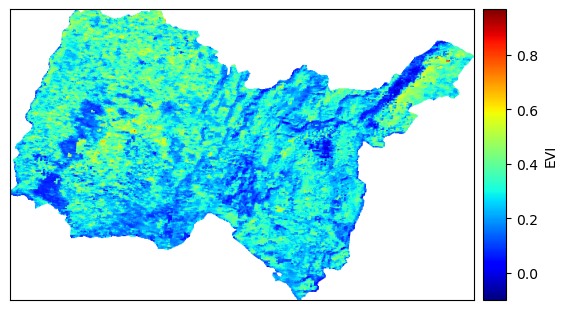

In [5]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(res["valid_lat"]),  urcrnrlat=np.max(res["valid_lat"]),
            llcrnrlon=np.min(res["valid_lon"]), urcrnrlon=np.max(res["valid_lon"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(res["valid_lon"], res["valid_lat"], c=res["valid_data"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

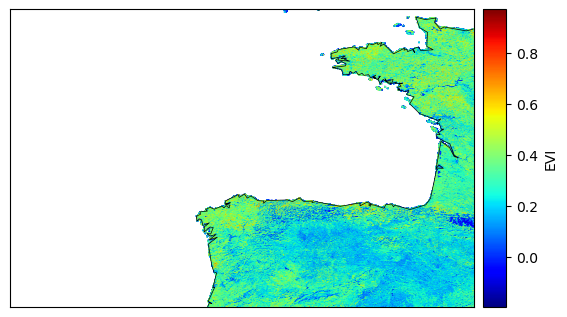

In [49]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data1["lats"]),  urcrnrlat=np.max(data1["lats"]),
            llcrnrlon=np.min(data1["lons"]), urcrnrlon=np.max(data1["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data1["lons"], data1["lats"], c=data1["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

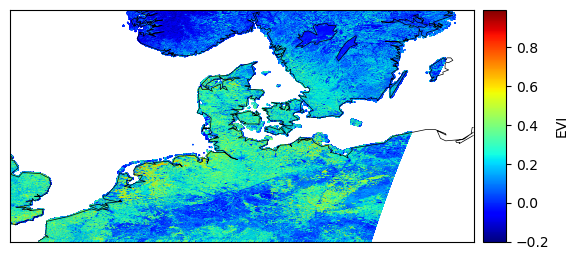

In [50]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data2["lats"]),  urcrnrlat=np.max(data2["lats"]),
            llcrnrlon=np.min(data2["lons"]), urcrnrlon=np.max(data2["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data2["lons"], data2["lats"], c=data2["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()

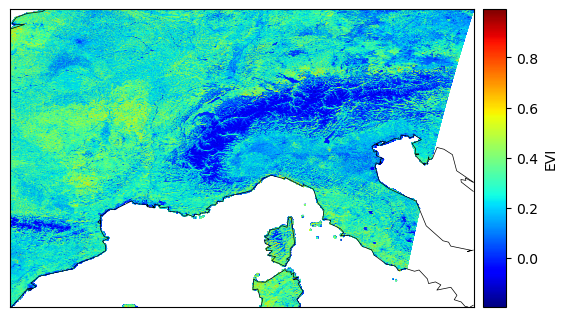

In [51]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(data3["lats"]),  urcrnrlat=np.max(data3["lats"]),
            llcrnrlon=np.min(data3["lons"]), urcrnrlon=np.max(data3["lons"]))
m.drawcoastlines(linewidth=0.5)
m.scatter(data3["lons"], data3["lats"], c=data3["datas"], s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()